# Anomaly detection 

We are going to follow the guidelines displayed in the data exploration notebook.

We are going to exploit all the strategies seen in class, and we're going to offer two options to show to the experts for validation.

The intersection of all the anomalies found by the different methods will give a set of almost certain anomalies while the union will give a wider set of anomalies.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [84]:
dataset = pd.read_csv('data/dataset.csv')
dataset[['day', 'cycle', 'window']] = dataset['day_cycle_window'].str.split('_', expand=True)
dataset.index = dataset['day_cycle_window']
dataset = dataset[['day', 'cycle', 'window'] + [col for col in dataset.columns if col not in ['day_cycle_window', 'day', 'cycle', 'window']]]

##### Collapse the windows to their mean, as said in the exploratory analysis #####
dataset = dataset.groupby(['day', 'cycle','window'], as_index=False).mean()
dataset = dataset.sort_values(['day', 'cycle', 'window'])
dataset.head()

,day,cycle,window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1,1,1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060
1,1,1,10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565
2,1,1,11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938
3,1,1,12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699
4,1,1,13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059


We first perform all the manipulations on a given (day, cycle) pair, and then we will generalize to the whole pairs and the end of the notebook.

In [85]:
day = np.random.choice(dataset['day'].unique())
cycle = np.random.choice(dataset[dataset['day'] == day]['cycle'].unique())
print(f'day: {day}, cycle: {cycle}')

day: 4, cycle: 4


Explained Variance for Component 1: 0.7899
Explained Variance for Component 2: 0.1027
Explained Variance for Component 3: 0.0627

Cumulative Explained Variance: 0.9553


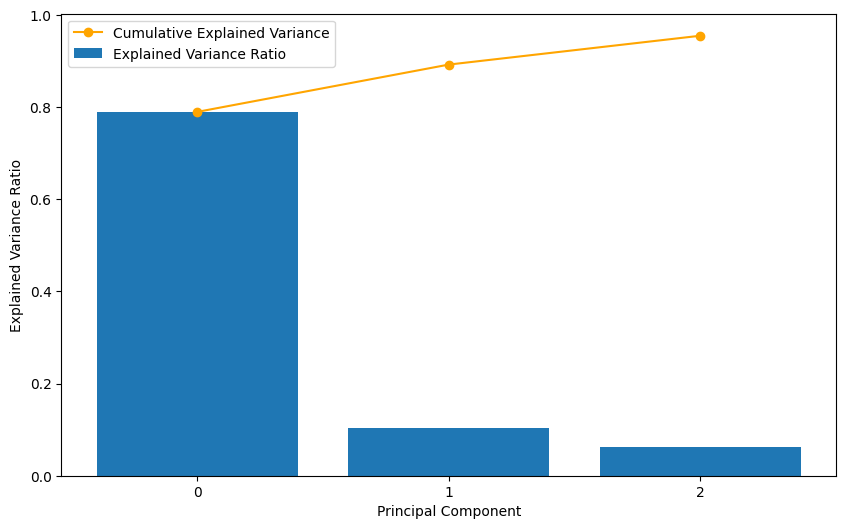

In [86]:
data_day_cycle = dataset[(dataset['day'] == day) & (dataset['cycle'] == cycle)].reset_index(drop=True)

scaler = StandardScaler()
data_day_cycle_scale = scaler.fit_transform(data_day_cycle)

pca = PCA(n_components=3)
data_day_cycle_scale_pca = pca.fit_transform(data_day_cycle_scale)
data_day_cycle_scale_pca = pd.DataFrame(data_day_cycle_scale_pca, columns=['PC1', 'PC2', 'PC3'])
data_day_cycle_scale_pca = pd.concat([data_day_cycle_scale_pca, data_day_cycle[['day', 'cycle', 'window']]], axis=1)

explained_variance_ratio = pca.explained_variance_ratio_

for i, ratio in enumerate(explained_variance_ratio):
    print(f"Explained Variance for Component {i + 1}: {ratio:.4f}")

cumulative_explained_variance = explained_variance_ratio.cumsum()
print(f"\nCumulative Explained Variance: {cumulative_explained_variance[-1]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(3), explained_variance_ratio, label='Explained Variance Ratio')
plt.plot(range(3), cumulative_explained_variance, label='Cumulative Explained Variance', marker='o', color='orange')
plt.xticks(range(3))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.show()

Some (day, cycle) combinations have a really strong principal component, but this is not the case for all the pairs. It's why we opt for 3 dimensions for the PCA, in order to keep it visualizable and because the cumulative explained variance is already sufficient (around 80%).

In [87]:
def plot_3d_anomaly_score(df, outlier_detection_model, trained_outlier_detection_model):
    if outlier_detection_model == 'Local Outlier Factor':
        score = trained_outlier_detection_model.negative_outlier_factor_
        # Normalize LOF scores to [-1, 1] range
        score = 2 * (score - min(score)) / (max(score) - min(score)) - 1
    else:
        score = trained_outlier_detection_model.decision_function(df[['PC1', 'PC2', 'PC3']])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(df['PC1'], df['PC2'], df['PC3'], c=score, cmap='RdYlGn')
    
    fig.colorbar(scatter, label='Anomaly Score', pad=0.2)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    plt.title(f'{outlier_detection_model} Anomaly Score')
    plt.show()
    
    anomalies = df[score < 0]
    print(f'{anomalies=}')

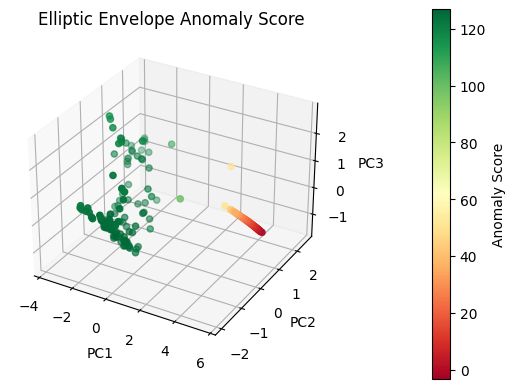

anomalies=          PC1       PC2       PC3 day cycle window
135  5.532452  0.626085 -0.312605   4     4     77
136  5.613200  0.637285 -0.337971   4     4     78


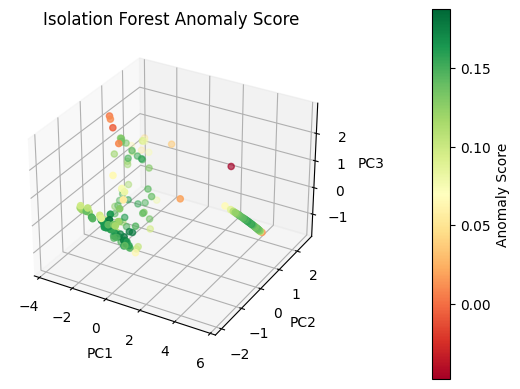

anomalies=          PC1       PC2       PC3 day cycle window
83  -2.186608 -0.144351  2.566628   4     4      3
137  2.670524  1.645732  0.902667   4     4     79


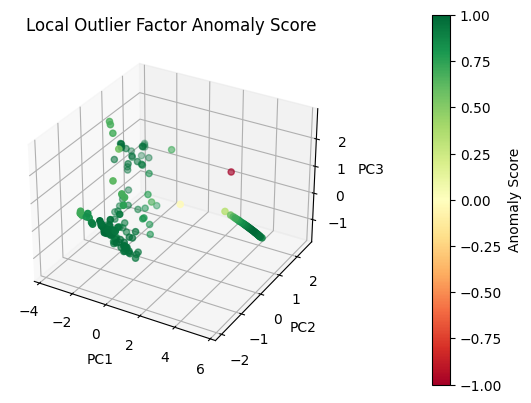

anomalies=          PC1       PC2       PC3 day cycle window
93   1.701311 -0.100346  0.654923   4     4     39
137  2.670524  1.645732  0.902667   4     4     79


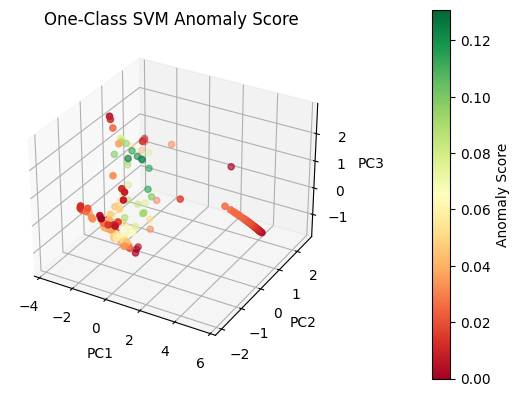

anomalies=          PC1       PC2       PC3 day cycle window
27  -0.347391 -0.611840 -1.382011   4     4    123
52  -2.923081  0.081164 -1.414453   4     4    146
72  -2.675996  0.086714  2.770365   4     4      2
136  5.613200  0.637285 -0.337971   4     4     78
137  2.670524  1.645732  0.902667   4     4     79


In [88]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

outlier_detection_model_names = ['Elliptic Envelope', 'Isolation Forest', 'Local Outlier Factor', 'One-Class SVM']
outlier_detection_models = [EllipticEnvelope(contamination=0.01), IsolationForest(contamination=0.01), LocalOutlierFactor(contamination=0.01), OneClassSVM(nu=0.01)]

for outlier_detection_model, outlier_detection_model_name in zip(outlier_detection_models, outlier_detection_model_names):
    trained_outlier_detection_model = outlier_detection_model.fit(data_day_cycle_scale_pca[['PC1', 'PC2', 'PC3']])
    plot_3d_anomaly_score(data_day_cycle_scale_pca, outlier_detection_model_name, trained_outlier_detection_model)
    plt.show() 

We can see that each one of the 4 methods give different results. This is nice here because each one has a different defition of how an anomaly is defined. By taking the union and the intersection of theses sets at the end, we will be able to give a wide interval of possible anomalies.

It's time now to do the study of all the possible combinations and give our final results.

In [89]:
all_anomalies_union = set()
all_anomalies_intersection = set()

for day in dataset['day'].unique():
    for cycle in dataset[dataset['day'] == day]['cycle'].unique():
        data_day_cycle = dataset[(dataset['day'] == day) & (dataset['cycle'] == cycle)].reset_index(drop=True)
        data_day_cycle_scale = scaler.transform(data_day_cycle)
        data_day_cycle_scale_pca = pca.transform(data_day_cycle_scale)
        data_day_cycle_scale_pca = pd.DataFrame(data_day_cycle_scale_pca, columns=['PC1', 'PC2', 'PC3'])
        data_day_cycle_scale_pca = pd.concat([data_day_cycle_scale_pca, data_day_cycle[['day', 'cycle', 'window']]], axis=1)

        anomalies_day_cycle_intersection = {(int(day), int(cycle), int(window)) for window in data_day_cycle['window']}
        anomalies_day_cycle_union = set()

        # We find the anomalies for each model, to then be able to do the intersection and union of the anomalies found by each model
        for outlier_detection_model, outlier_detection_model_name in zip(outlier_detection_models, outlier_detection_model_names):
            anomalies = set()        
            trained_outlier_detection_model = outlier_detection_model.fit(data_day_cycle_scale_pca[['PC1', 'PC2', 'PC3']])

            if outlier_detection_model_name == 'Local Outlier Factor':
                score = trained_outlier_detection_model.negative_outlier_factor_
            else:
                score = trained_outlier_detection_model.decision_function(data_day_cycle_scale_pca[['PC1', 'PC2', 'PC3']])
            
            anomalies = data_day_cycle_scale_pca[score < 0]

            # Converting the anomalies to a set of tuples, so that we can use set operations
            anomalies = set(tuple(row) for row in anomalies[['day', 'cycle', 'window']].astype(int).itertuples(index=False))

            anomalies_day_cycle_intersection = anomalies.intersection(anomalies_day_cycle_intersection)
            anomalies_day_cycle_union = anomalies.union(anomalies_day_cycle_union)
        
        # We add the anomalies of the current day and cycle to the set of all anomalies
        all_anomalies_intersection = all_anomalies_intersection.union(anomalies_day_cycle_intersection)
        all_anomalies_union = all_anomalies_union.union(anomalies_day_cycle_union)

print(f'{all_anomalies_intersection=}')
print(f'{all_anomalies_union=}')

/Users/accoumar/Desktop/supaero/sdd/ctf2023/venv/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (6). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
/Users/accoumar/Desktop/supaero/sdd/ctf2023/venv/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


all_anomalies_intersection={(1, 2, 1), (2, 1, 1), (1, 3, 1), (3, 1, 1), (1, 5, 66), (4, 2, 1)}
all_anomalies_union={(2, 1, 107), (3, 1, 94), (4, 4, 44), (3, 3, 36), (1, 2, 164), (2, 1, 125), (3, 1, 112), (1, 5, 71), (4, 2, 181), (1, 5, 89), (1, 1, 55), (1, 2, 20), (4, 1, 11), (4, 4, 147), (3, 3, 139), (2, 2, 44), (3, 2, 31), (1, 2, 38), (3, 3, 157), (4, 2, 55), (2, 2, 62), (2, 3, 27), (3, 2, 49), (1, 2, 56), (4, 2, 73), (4, 3, 38), (4, 4, 3), (2, 3, 45), (1, 3, 2), (4, 3, 56), (3, 1, 71), (2, 3, 63), (4, 4, 21), (3, 3, 13), (2, 1, 102), (3, 1, 89), (1, 5, 48), (4, 4, 39), (3, 3, 31), (1, 2, 159), (2, 1, 120), (3, 1, 107), (1, 5, 66), (4, 2, 176), (1, 2, 177), (1, 5, 84), (1, 1, 32), (4, 4, 124), (3, 3, 116), (1, 1, 50), (1, 2, 15), (4, 1, 6), (4, 4, 142), (3, 3, 134), (2, 2, 39), (3, 2, 26), (1, 1, 68), (1, 2, 33), (4, 4, 160), (3, 3, 152), (4, 2, 50), (4, 3, 15), (2, 2, 57), (2, 3, 22), (3, 2, 44), (1, 2, 51), (4, 2, 68), (4, 3, 33), (2, 2, 75), (2, 3, 40), (2, 1, 79), (3, 1, 66), (4,

## Conclusion

Finally, we have the two lower bounds of the spectrum of anomalies. If we aim at security, we have to look at the union of the anomalies provided by the different methods. If we run out of time or do not have a big budget, we can focuse on the intersected anomalies.

All this has to be discussed with the expert, which ideally helps us to finetune the parameters of the different models with the help of the visualizations we made for each model.

The expert can even opt for chosing one model over the others, if he thinks it is more appropriate to the specific use case.
If two models or more are needed to fully grasp the spectrum of the possible anomalies, the proposed method can be followed.